# Flow direction
In this file is implemented the D8 algorithm. The code assigns a unique flow direction to each grid cell by finding the steepest slope between the central cell and its eight neighbouring cells.It is assigned a value for all the grid cells related to the assigned direction accordingly to the following table:

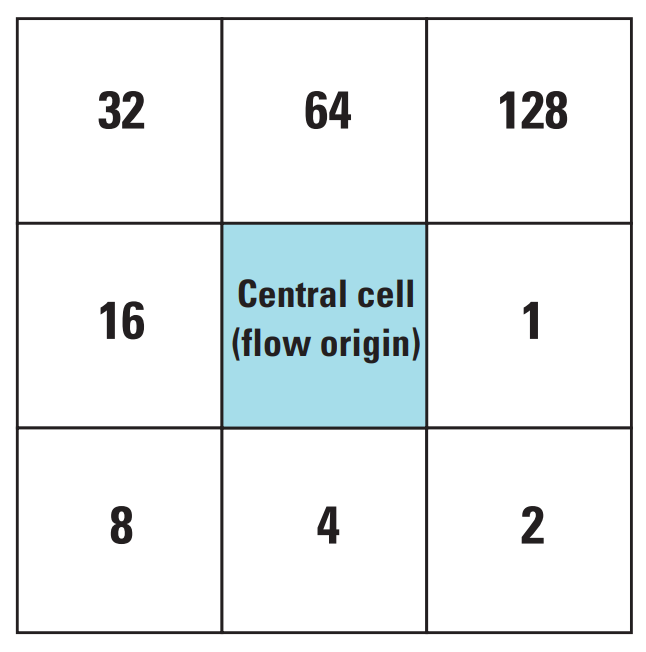

*table from Westenbroek et al., 2010*

The program requires in input a Digital Elevation Model DEM grid for the the area of interest. For an assesment in the pan-European area, it is possible to download the data from the [Copernicus Land Monitoring Service database](https://land.copernicus.eu/imagery-in-situ/eu-dem/eu-dem-v1.1). The data loading require a Copernicus account log in. The downloaded  DEM raster file is pre-processed in [QGIS](https://qgis.org/en/site/forusers/download.html) where it is clipped and upscaled to pixel resolution of 250 x 250 m (the same used by Soilgrid for the soil data).


# Libraries installation

The first library installed is  rasterio. this library allowed to elaborate save and load the raster files. it will be used to elaborate the maps loaded form SoilGrid. The secon library installed is Numba that allowed to accelerate Python. Numba translates Python functions to optimized machine code at runtime using the industry-standard LLVM compiler library.

In [2]:
pip install rasterio

     |████████████████████████████████| 19.3MB 1.6MB/s 


In [22]:
pip install numba

#Data loading

In the following section are loaded the DEM data.

To run this section it is necessary to put in the code directory a file named DEM_clip.tif that contains a raster file of the DEM of the area of interest. It is recommended to realize a raster file that cover the same area and has the same resolution of the data loaded for the other SWB input.


In [23]:
#import the library rasterio and open the DEM file
import rasterio

DEM = rasterio.open("DEM_clip.tif", driver="GTiff")

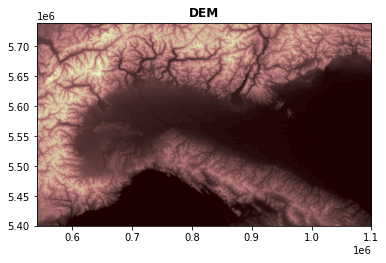

In [67]:
# load the plot function of rasterio
from rasterio import plot as rplt
%matplotlib inline
# plot the georeferenced data
rplt.show(DEM, title='DEM', cmap='pink')

#Flow direction evaluation

In the following section is defined a function that evaluate in which of the 8 neighbour cells is contain the minimum elevation value. The flow will be directed toward this cell. If none of the 8 neighbour cells has lower elevation level than the centre cell, value of 0.5 is assigned.

Afterall the obtained results are plotted 

In [ ]:
#convert the raster data into a numpy array.
pixel_elv = DEM.read(1)
#import the needed library
from numba import jit
import numpy as np

#create some function input
y = pixel_elv.shape[0]
x = pixel_elv.shape[1]
flow_d = np.zeros([pixel_elv.shape[0],pixel_elv.shape[1]])

#define the functio to compute the rirection
@jit 
def D8_model(pixel_elv,x,y,flow_direction): # Function is compiled to machine code when called the first time
  for i in range(y):
      for j in  range(x):
        if i==0 and j==0:
          p = np.argmin([pixel_elv[i,j],pixel_elv[i,j+1],10000,10000,10000,10000,10000,pixel_elv[i+1,j],pixel_elv[i+1,j+1]])  
        elif i==0 and j==(x-1):
          p = np.argmin([pixel_elv[i,j],10000,10000,10000,10000,pixel_elv[i,j-1],pixel_elv[i+1,j-1],pixel_elv[i+1,j],10000])
        elif i==(y-1) and j==(x-1):
          p = np.argmin([pixel_elv[i,j],10000,10000,pixel_elv[i-1,j],pixel_elv[i-1,j-1],pixel_elv[i,j-1],10000,10000,10000])
        elif i==(y-1) and j==0:
          p = np.argmin([pixel_elv[i,j],pixel_elv[i,j+1],pixel_elv[i-1,j+1],pixel_elv[i-1,j],10000,10000,10000,10000,10000])
        elif i==0:
          p = np.argmin([pixel_elv[i,j],pixel_elv[i,j+1],10000,10000,10000,pixel_elv[i,j-1],pixel_elv[i+1,j-1],pixel_elv[i+1,j],pixel_elv[i+1,j+1]])
        elif  j==0:
          p = np.argmin([pixel_elv[i,j],pixel_elv[i,j+1],pixel_elv[i-1,j+1],pixel_elv[i-1,j],10000,10000,10000,pixel_elv[i+1,j],pixel_elv[i+1,j+1]])
        elif i==(y-1):
          p = np.argmin([pixel_elv[i,j],pixel_elv[i,j+1],pixel_elv[i-1,j+1],pixel_elv[i-1,j],pixel_elv[i-1,j-1],pixel_elv[i,j-1],10000,10000,10000])
        elif j==(x-1):
          p = np.argmin([pixel_elv[i,j],10000,10000,pixel_elv[i-1,j],pixel_elv[i-1,j-1],pixel_elv[i,j-1],pixel_elv[i+1,j-1],pixel_elv[i+1,j],10000])
        else:
          p = np.argmin([pixel_elv[i,j],pixel_elv[i,j+1],pixel_elv[i-1,j+1],pixel_elv[i-1,j],pixel_elv[i-1,j-1],pixel_elv[i,j-1],pixel_elv[i+1,j-1],pixel_elv[i+1,j],pixel_elv[i+1,j+1]])
        flow_direction[i,j] = p  
  return flow_direction

#call the defined function
flow_d = D8_model(pixel_elv,x,y,flow_d)


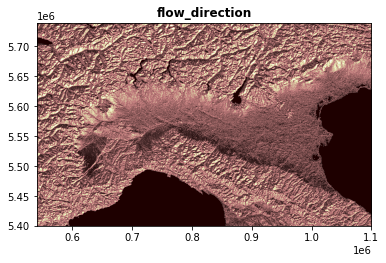

In [66]:
# save flow_direction
flow_direction = DEM.meta
flow_direction.update(
    dtype=rasterio.float32,
    count = 1)

# Create the file
with rasterio.open('flow_direction.tif', 'w', **flow_direction) as dst:
        dst.write_band(1, flow_d.astype(rasterio.float32))

#load and plot the saved data
FD = rasterio.open("flow_direction.tif", driver="GTiff")
rplt.show(FD, title='flow_direction', cmap='pink')